# R-CNN

We will now build a R-CNN Model implementing the selective search algorithm im openCV.

We will use ResNet50 for the purpose of classification. We will fine-tune this model using the airplanes dataset.

First, we will build a function predicting the IoU score for the bounding boxes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! unzip "Airplanes_Annotations.zip"
! unzip "Images.zip"

Archive:  Airplanes_Annotations.zip
   creating: Airplanes_Annotations/
 extracting: Airplanes_Annotations/airplane_095.csv  
  inflating: Airplanes_Annotations/airplane_094.csv  
  inflating: Airplanes_Annotations/airplane_093.csv  
  inflating: Airplanes_Annotations/airplane_092.csv  
  inflating: Airplanes_Annotations/airplane_091.csv  
  inflating: Airplanes_Annotations/airplane_090.csv  
 extracting: Airplanes_Annotations/airplane_089.csv  
 extracting: Airplanes_Annotations/airplane_088.csv  
 extracting: Airplanes_Annotations/airplane_087.csv  
 extracting: Airplanes_Annotations/airplane_086.csv  
  inflating: Airplanes_Annotations/airplane_085.csv  
 extracting: Airplanes_Annotations/airplane_084.csv  
  inflating: Airplanes_Annotations/airplane_083.csv  
  inflating: Airplanes_Annotations/airplane_082.csv  
 extracting: Airplanes_Annotations/airplane_081.csv  
 extracting: Airplanes_Annotations/airplane_080.csv  
 extracting: Airplanes_Annotations/airplane_079.csv  
  inflatin

In [3]:
# Let us import all the required libraries

import cv2,os, keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

In [4]:
def iou(boxA, boxB):
       
   # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
   # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
   # compute the area of both the prediction and ground-truth
   # rectangles
    boxAArea = (boxA[2] - boxA[0] ) * (boxA[3] - boxA[1] )
    boxBArea = (boxB[2] - boxB[0] ) * (boxB[3] - boxB[1] )
   
   # compute the intersection over union by taking the intersection
   # area and dividing it by the sum of prediction + ground-truth
   # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
   
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Step 1 - Making Region Proposals from selective search algorithm and making them suitable for training ResNet

In [5]:
def selective_search(img):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    ss.setBaseImage(img)
    
    ss.switchToSelectiveSearchFast()
    
    rects = ss.process()
    
    return rects

In [6]:
path = "//home//web_slinger//Documents//Machine Learning Projects//Object Detection Algorithms//R-CNN//"

train_images=[]
train_labels=[]

# we will set a limit on how many rois to take from one image 
pos_limit = 10
neg_limit = 10

max_proposals = 2000

for e,image in enumerate(os.listdir("Images")):
    if not image.startswith("airplane"):
        continue
    img_path = os.path.join("Images",image)
    img = cv2.imread(img_path)

    
    # Now we will find all the Region Proposal using selective search 
    rois = selective_search(img)
    
    # Now we need to obtain the ground truth labels for each images from annotation folder
    file = image.split(".")[0] + '.csv'
    annot_path = os.path.join('Airplanes_Annotations',file)
    
    df = pd.read_csv(annot_path)
    gtvalues = []
    
    pos_cnt, neg_cnt = 0,0
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append([x1,y1,x2,y2])
        
    rects = []
    for (x,y,w,h) in rois:
        rects.append([x,y,x+w,y+h])
        
    for rect in rects[:max_proposals]:
        
        x1,y1,x2,y2 = rect
        
        for gtvalue in gtvalues :
            
            x3,y3,x4,y4 = gtvalue
            IoU = iou(rect, gtvalue)
            
            if IoU > 0.7 and pos_cnt <= pos_limit :
                
                Reg_prop = img[y1:y2,x1:x2]
                resized = cv2.resize(Reg_prop,(224,224),interpolation=cv2.INTER_CUBIC)
                train_images.append(resized)
                train_labels.append(1)
                pos_cnt += 1
                
            # We need to make a full overlap condition in order to ensure that fully overlapped boxes are not
            # classified as negative 
            
            fully_overlap = (x1 >= x3) and (x2 <= x4) and (y1 >= y3) and (y2 >= y4)
            
            if not fully_overlap and IoU < 0.1 and neg_cnt <= neg_limit :
                
                Reg_prop = img[y1:y2,x1:x2]
                resized = cv2.resize(Reg_prop,(224,224),interpolation=cv2.INTER_CUBIC)
                train_images.append(resized)
                train_labels.append(0)
                neg_cnt += 1
                
    
    

In [7]:
len(train_images)

13578

## Step 2 - Fine Tuning the network on the dataset
**Now that we have created an object detection dataset, we will now fine-tune our model.**

In [56]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D,Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.image import non_max_suppression
from tensorflow.keras.models import Model
import os

In [9]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_tensor=Input(shape=(224, 224, 3)))

head_model = base_model.output
#head_model = AveragePooling2D(pool_size=(2, 2))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dense(16, activation="relu")(head_model)
head_model = Dense(1, activation = "sigmoid")(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

for layer in base_model.layers :
    layer.trainable = False 

58889256/58889256 [==============================] - 4s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
X_train, X_test , y_train, y_test = train_test_split(np.array(train_images[:5000]),np.array(train_labels[:5000]),test_size=0.10,shuffle = True)


In [12]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

opt = Adam(learning_rate = 0.0001)
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer=opt,metrics=["accuracy"])


In [17]:
history = model.fit(aug.flow(X_train,y_train, batch_size = 8),batch_size = 8,epochs = 10)

Epoch 1/10
563/563 [==============================] - 63s 112ms/step - loss: 0.3490 - accuracy: 0.8598
Epoch 2/10
563/563 [==============================] - 65s 115ms/step - loss: 0.2859 - accuracy: 0.9013
Epoch 3/10
563/563 [==============================] - 57s 101ms/step - loss: 0.2143 - accuracy: 0.9251
Epoch 4/10
563/563 [==============================] - 58s 102ms/step - loss: 0.2267 - accuracy: 0.9338
Epoch 5/10
563/563 [==============================] - 69s 123ms/step - loss: 0.2099 - accuracy: 0.9376
Epoch 6/10
563/563 [==============================] - 58s 102ms/step - loss: 0.2211 - accuracy: 0.9391
Epoch 7/10
563/563 [==============================] - 61s 109ms/step - loss: 0.2106 - accuracy: 0.9469
Epoch 8/10
563/563 [==============================] - 57s 101ms/step - loss: 0.1989 - accuracy: 0.9464
Epoch 9/10
563/563 [==============================] - 58s 103ms/step - loss: 0.1829 - accuracy: 0.9502
Epoch 10/10
563/563 [==============================] - 61s 108ms/step - l

In [18]:
train_loss = history.history['loss']
train_accuracy= history.history['accuracy']

results = model.evaluate(X_test,y_test, batch_size = 16)
print("test loss, test acc:", results)

32/32 [==============================] - 5s 92ms/step - loss: 0.1930 - accuracy: 0.9520
test loss, test acc: [0.1929677128791809, 0.9520000219345093]


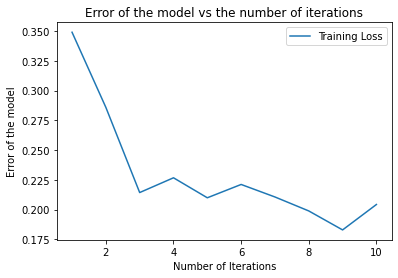

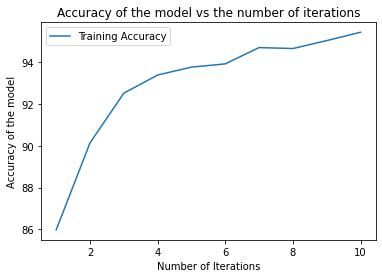

In [19]:
plt.figure()
plt.title("Error of the model vs the number of iterations")
plt.plot(range(1,11), train_loss, label = "Training Loss")
plt.xlabel("Number of Iterations")
plt.ylabel("Error of the model")
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy of the model vs the number of iterations")
plt.plot(range(1,11), np.array(train_accuracy)*100, label = 'Training Accuracy')
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy of the model")
plt.legend()
plt.show()


## Step 3 - Predicting the Results on a Test Image

In [23]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import imagenet_utils

The image we are going to use for prediction is


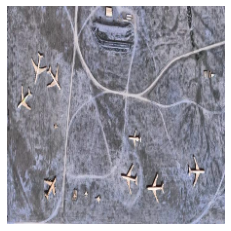

In [78]:
# Let us import a image for prediction

pred_img = cv2.imread("Images/Planes11.jpg")
pred_img = cv2.resize(pred_img, (224,224))

print("The image we are going to use for prediction is")
plt.imshow(pred_img)
plt.axis("off")
plt.show()

In [79]:
# First step is to find out all the Region Proposals

reg_props = selective_search(pred_img)

props_limit = 200

boxes = []
proposals = []

for props in reg_props[:props_limit]:
  (x,y,w,h) = props
  boxes.append((x,y,x+w,y+h))
  roi = pred_img[y:y+h,x:x+w]

  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  roi = cv2.resize(roi, (224,224),interpolation=cv2.INTER_CUBIC)

	# further preprocess the ROI
  roi = img_to_array(roi)
  roi = preprocess_input(roi)
  proposals.append(roi)

In [80]:
# Next step is to classify the region proposals

proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="float16")

# classify each of the proposal ROIs using fine-tuned model

results = model.predict(proposals)

7/7 [==============================] - 1s 176ms/step


In [83]:
# Third step in prediction will be to apply non-maximum suppression

# For applying NMS we need to find all the positive predictions and their score 

score_limit = 0.7

fin_props, scores = [],[]

for i in range(len(results)) :

  if results[i] >= score_limit :

    fin_props.append(boxes[i])
    scores.append(results[i])


fin_props, scores = tf.convert_to_tensor(fin_props, dtype = tf.half), tf.convert_to_tensor(scores, dtype = tf.half)
indices = non_max_suppression(boxes = fin_props,scores = tf.squeeze(scores, axis =1),max_output_size = 10, iou_threshold = 0.5)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

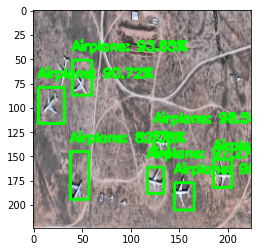

In [85]:
# Now the last step is just visualizing the result by drawing the bounding box and printing the associated score

clone = pred_img.copy()

if len(indices) == 0:
    print("No Object detected in the image")

for index in indices:
    
    score, box = float(scores[index]), fin_props[index]

    (startX, startY, endX, endY) = box.numpy()
    cv2.rectangle(clone, (int(startX), int(startY)), (int(endX), int(endY)),(0, 255, 0), 2)
    plt.figure()
    clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)

    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = "Airplane: {:.2f}%".format(score * 100)
    cv2.putText(clone, text, (int(startX), int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
plt.imshow(clone)
plt.show()

**As we can see from the above result Our object detector is working really well but at the same time we can see that it failed to detect one plane in the top left corner. It is because of the NMS algorithm as the plane is really close to the other two planes. To remedy this, we can use Soft-NMS.**